# warped signal modelling training

This notebook will learn the auto-regressive models of the warped frequency components of a signal.

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/obama.wav"      # specify sound location
fs_desired = 8000                 # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                # number of taps of warped filter bank
z_pole = 0.4092                    # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow         # specify windowing function from fourier.jl file

# inference and modelling
AR_order = 20                       # order of auto-regressive model
iterations = 3                     # number of iterations for variational message passing
Λ_meas = 1e10                      # assumed precision of measurement noise

# save model
save_file = "../inferred_values/speech_AR_20.h5" # file in which model parameters are saved
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[20*fs_time+1:23*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCnCOW8wa2AvsC2BL3R5W49mfDVvQbAob3dP4e+AVH2vZZYaTxgBAu9CZfmPO4m7r2QBDm9BUgRPnOnYD39fSg9Hupave+yprw3dLc9gd8iO8F+a72y35i8LSgMPVvOYj7uO+090rUIvgCzSz2afRQ++WxGPrrIGj1J1Eu+9WEVuUv/8byzSAW+6pLavQzAgr6Zld69M4guvLO5YDyyPbc9vyLQvVZskb22nLU9To6SPSU4nD2pd/K80HVUvQV9PT1KJw+77lO2vJXQHjwySjw91LlDPuzn5D3ewZC96/jQPRb28z2IKRg+sQo9PPjLMb69Iqk8MbJ2vVxQBr7YjHW9ky89vosUib3ef5e8TDHqvMTAhT1I0gm+bZyNvTqlpD29lLo993ANPugwkzpQky+9kbk0PONVQb0dyg29CQAFPdA5xD19Zlc+bTqgPVKLlr2cW8M9Wh3BPSHxAT5yHeS8CHMivlG+zTyig6a9a5H9vfVFsr0tPia+cjssvb6YaL3OlBe9liEWPNLv672fF128mGPTPUGU3T1Pc+A9K704vQ9nZb2cfFC80s6hvBocqDo6DLA9ySEFPhfoLD7xhFw9Wuyxva3Gzj1YuPE99XX3PS/h5rx21SO+T8b2PPrmu71tB769oLSZvSXvK75Jv0+9fDezvXHwQr2aM/E7gOvYvXEy1TmvRMM9oG2LPdwMMz1+/KO9QbElvahdhzxjlqY8kOdePaSQWT2hZQM+GUwQPsSClD05cLC83a3EPZ02DD6d9pQ9Zy0cvbg/Ib70j4y8AUR3vX6WjL1+GRG9SOIIvleTo7047b+9Ey4ivWqKA7uXB+K9Kv/QvNqORz2Mmn09r/fTPDzrg70iAXe8o66WPKc8CD09HZk9ZDL7PFWvyD0nj/I902iUPeOIDT0evGQ9gRaiPaJ4Az0QwRa9bPlmvQZhKrsMUFs8kNaNvPl0Kr0M43S96uCzvYe2xL0p36C6ruyxPMZzhL1d1FW90X4mvW3NFbvGaia8p1ZKvZwLebs8Dp27xPmtPGY2Hj0SPQe8jJ5gPGDY9zy2rAY985yhPK5DTrwq6Aw9ROxhPURgFT1Ca089jAY3PfMC3Tz6ep08LQA6vCbX0jrCh7a6njyduTnO1DwPfwC7y2J0va8ulL0PPrO9fApnvWsEorz5nia9cK7wvNduxrwO1tq8CyfsvFoi6bwcWqW8tfnbvH+Vqrwnzkc79SqSPOgg1DyUcyU9zJ6JPbB5Ej2U1T09yeVVPQ6HQz2R7WA9UvxRPRlKNj0QlDw9vDm7O+4ay7x7phe9pB1yvbG8Kb2i4JO8m3M5vOTBl7zkEym9Ly1VvYyRtLzNz3u8jzyqu4iKDbz8Ca682czavPI9PL3Y7i29b8wfuzZUCzsqo+k40GutPFzjpjwDRFk9va52PWKJmj0CnZg9zqBiPUVi5DxIldo8K8jzO5LReLtKiIg74SUlPPo6BrsIOKG8tSbovAXfCb2GUhS9VNUAvUJolbwkDI+89bobvcMDQL1Ljsu8EMAmvLiGprtBTd68VBQAvSyYW72bbTq9BDQfvNxkojwNWh49Qo9fPU7fVz1lBUE9Sh4ZPb+OpzzBfug8WGsYPZKUsDyfdBY9dGbjPIJaiTx7puE8LbF5vJ9ClLuUIrC80XGBvXgNLb1XuTe9Kr0VvcPTHjwC9cE70A65vNbbKL3LkTm9eKYDvdey+byWaFm82UYxu2L0lby7Zqg6w2FuOkTWrLoqiaQ8Y0JSPKjgbT3RW6I9Dvx0PQcPNz2WcGg8DEkevKyeEjyzYqI8bkNZPItixjt76kO8P4CWvA8727neH2K8ZqkkvB3M4LycNzS9mRNcvBnuEbvM83888EU6PNhZ/Ly1pVa9MtdXvYfrer0vYRG96Iozu6SKkTyowl49LBQ6PUQZPT1JHxs962vnPLbOOj0JGQs9TNsSPXcrAj2pnUs74OAcPETD3Lstto+89PT3u74zObwelTO8rzLZO6H3qruRRZa8vPrYvH+fIr0yQku9j8hNvVLrH71yTYa9kkaJvbQVO73SsM+8KnXZuZQVgbov2go7b/mkPKc0MTwSBQY9soGAPQpNUz3O+G092EhSPa/MHD3FjBc9XVuWPJ6rATw5D9Y7bP01vCkkkTs5Vr67cAAiPEM/7jxtgTk7Lw9xvPCoJr3tTHO9tOMjvZ7qNL1f/l69c1bhvAvvGL0OGd28vRocvCVfJ7wOp3m8/9YNvLWaV7wVUoU8jrOJPO06DT3u+1A9a4FtPQGypz2xXV89ufICPXgbMj0tXSs9dAVFPcny9Dz7c8O7W3SyvOw5Cr18Xsq8GO6buylumbvzv8i8da8ZvDol4rx/KU68WkEAverFhr0dbKC9O6Wevbezi735Rka9wK4Rvd2fb7zyMJC75hrgO3DlrjzXIFI8jjzNPIziVj0qSoo9E62ePc41kz0aolw9eCD1PAgrebs8NgW8onu/vOPICb2OWvm8HNrBuzOOITynq648f1wou7oX4btw7eW8BWsuvfxYg73EGrO9RVixvaNqqL2ik5G9Znc5vTK8+ryBJ2O8l4LXup3bJDx+ki09/I+PPRnMwT2DH8U9Qv+VPSxJWT2SKU898iCbPHz7Ej2z6cM8teByPHX6uTx48z88TcYtPDtXOTwZGkW853urOueCn7yq5E+9hpc7vXKLnL16m269it4lvQBKE73qnNa8oyI6vU3AGL3pC228L5NFPBAJUj3FVx49289APZI/bz28cWY9antnPeUHjD33DIc9nat/PYh/Xz10Rg09+5wOPZL2pTwQY0M8RAeTPETxWDxAT4u60DDKvPlVR704xBi91fhUvbA7W72ef1K9DDOSvYutW73uF/i8x3ubvD1Cbjz7xC48/s43PDicqLzkfBy9bThKvKmhkDlrKWA9ZNGKPdg7lD1Yh5o9b5CYPXh9pj3kJaI9KdRTPUegVD2RmYY8XfE/uw2Am7tAePi6g/EKuo4y0rz4foS9k1mUvUnttr1k3Yy9zdE8vYZpQr2JU6K8MUwHvTtwHL0+uRO9tHdFvaKgeb3zBhq9D4cnvVCsr7wHpKC83ZmNu5d0HT1wD2E9Jz1oPbMwhD3j1Fg9Ze8XPYjF6DxHbIm8kbqqOyEIt7tdDBe9SBcWvWoImr1Hlye96JQDvbf48bx4wS68Yx4HvUPrSbzyE9y8YbRBvZXpQL1BDDy9bIMlvWmnRLyG8IO8tqmavDEYbLzdM4G8jkMrPZHYiDyisT897XKAPJqdPj220II9x4M4PULRHD2b+gE5uUqZvPXX2jl0xdi8pZd9vBmjm7zCueK8DWJXu+tWN7llOdu8UftqvddGgr3J0Xm9HDCFvDN5Ir2omTi988wKvaf8jb21sga8iJoCvZaMIjzieoQ8fEUjPSaCnT3lODc99qaoPYfOVD2cLS89nFxZPWsgODuAGeo8tNlKvA3YCD0YjZw9nDIJPRWLPT3DWzq9/sNxvMaVOr2aW5K8ElMAvJ1rA72IYDS7PMocvRW9ZbxkgDi9+NA1vQe/WLwjC/i8ovIIvHJuHL2qh1k9PokvPQqU9D182qw9TQOzPaAVabvOdom8eo7RPUjUWj3wO989g+kiuuAoKzzI55k9XsOjvCgQKT08i1K8xi0wvVELgrtSlj+91IYGu4haaL1gy4q92NHgvN1ovLzaNk29r1iWvD53Qb2NhiO9z0IoOykD+Dx0WIU9wNeSPXmrnj1iWsc9mKhtPZmxjbzLVxI+vwnRPbCiAT4FRYY87CC+vetVjD3aOou9nqoFvYGwSL0Syw++9X9EvYxdgb15DAK96fMBvZAbBr596kC9dji9OlQIA71U2Ac8Qti1vO3cTTsUajQ9jkO/PC/MXj0uh

## Visualize data

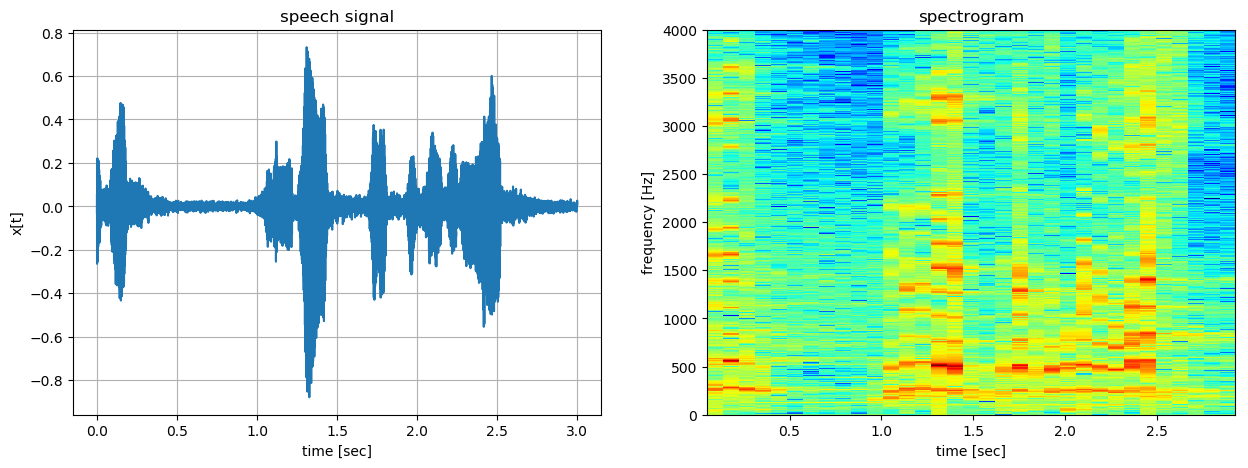

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_time))
mem_spec = Array{Complex{Float64},2}(undef, length(x_time), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_time)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_time[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
# remove zero, complex conjugate highest negative frequency, remove half
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components 
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
mem_spec_all = hcat(mem_spec_real, mem_spec_imag)
;

## Warped spectral distribution visualization

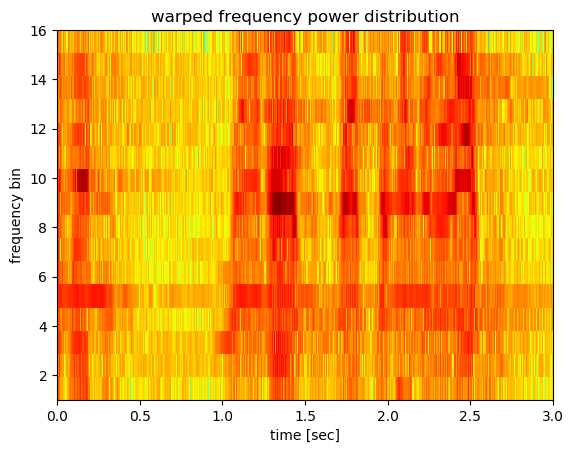

In [6]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Generative model and inference

In [7]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 232951163513217461 -->
 232951163513217461 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 6085483202559325231 -->
 6085483202559325231 
 
 clamp_2 
 
<!-- 232951163513217461--6085483202559325231 -->
 232951163513217461--6085483202559325231 
 
 clamp_2 
 1 out 
 2 m 
 
<!-- 7040442573947214437 -->
 7040442573947214437 
 
 clamp_3 
 
<!-- 232951163513217461--7040442573947214437 -->
 232951163513217461--7040442573947214437 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 2117452655103916767 -->
 2117452655103916767 
 
 placeholder_μ_Sprev 
 
<!-- 10686156070180357920 -->
 10686156070180357920 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 10686156070180357920--2117452655103916767 -->
 10686156070180357920--2117452655103916767 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 4898485521482618043 -->
 4898485521482618043 
 
 placeholder_Λ_Sprev 
 
<!-- 10686156070180357920--4898485521482618043 -->
 10686156070180357920--4898485521482618043 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 10404080605381338708 -->
 10404080605381338708 
 
 clamp_1 
 
<!-- 938550953835966426 -->
 938550953835966426 
 
 placeholder_Λ_θ 
 
<!-- 9449930252454073953 -->
 9449930252454073953 
 
 Gam 
 gamma_1 
 
<!-- 10919667742049704282 -->
 10919667742049704282 
 
 placeholder_a_γ 
 
<!-- 9449930252454073953--10919667742049704282 -->
 9449930252454073953--10919667742049704282 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 13790842426415840325 -->
 13790842426415840325 
 
 placeholder_b_γ 
 
<!-- 9449930252454073953--13790842426415840325 -->
 9449930252454073953--13790842426415840325 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 474487514001759269 -->
 474487514001759269 
 
 + 
 addition_1 
 
<!-- 474487514001759269--232951163513217461 -->
 474487514001759269--232951163513217461 
 
 v 
 1 out 
 3 in2 
 
<!-- 1367346299335498996 -->
 1367346299335498996 
 
 dot 
 dotproduct_1 
 
<!-- 474487514001759269--1367346299335498996 -->
 474487514001759269--1367346299335498996 
 
 x 
 1 out 
 2 in1 
 
<!-- 1367346299335498996--10404080605381338708 -->
 1367346299335498996--10404080605381338708 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 2615344950177092586 -->
 2615344950177092586 
 
 AR 
 autoregressive_1 
 
<!-- 1367346299335498996--2615344950177092586 -->
 1367346299335498996--2615344950177092586 
 
 S 
 1 y 
 3 in2 
 
<!-- 10597644731369042828 -->
 10597644731369042828 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 10597644731369042828--938550953835966426 -->
 10597644731369042828--938550953835966426 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 266214799590505915 -->
 266214799590505915 
 
 placeholder_μ_θ 
 
<!-- 10597644731369042828--266214799590505915 -->
 10597644731369042828--266214799590505915 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 2615344950177092586--10686156070180357920 -->
 2615344950177092586--10686156070180357920 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 2615344950177092586--9449930252454073953 -->
 2615344950177092586--9449930252454073953 
 
 γ 
 1 out 
 4 γ 
 
<!-- 2615344950177092586--10597644731369042828 -->
 2615344950177092586--10597644731369042828 
 
 θ 
 1 out 
 3 θ 
 
<!-- 7011188492866202004 -->
 7011188492866202004 
 
 placeholder_y 
 
<!-- 7011188492866202004--474487514001759269 -->
 7011188492866202004--474487514001759269 
 
 y 
 1 out 
 1 out

In [8]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, S, Sprev, γ, ids=[:Θ :S :Sprev :γ])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorith 
eval(Meta.parse(algo))
;

In [9]:
# specify memory array for results
all_μ_θ = Array{Array{Float64,1},1}(undef, size(mem_spec_all)[2])
all_Λ_θ = Array{Array{Float64,2},1}(undef, size(mem_spec_all)[2])
all_a_γ = Array{Float64,1}(undef, size(mem_spec_all)[2])
all_b_γ = Array{Float64,1}(undef, size(mem_spec_all)[2])

# loop through components
for bin = 1:size(mem_spec_all)[2]
    
    # specify frequency component
    spec_select = mem_spec_all[:,bin]
    
    # priors for each frequency coefficient
    current_a_γ = 0.001
    current_b_γ = 0.001
    current_Λ_θ = tiny*diagm(randn(AR_order))
    current_μ_θ = randn(AR_order)
    current_μ_Sprev = randn(AR_order)
    current_Λ_Sprev = tiny*diagm(randn(AR_order))

    # create progress bar for data to process
    p2 = Progress(length(spec_select), 1, "Observed component "*string(bin, pad=2)*"/"*string(size(mem_spec_all)[2])*": ")
    marginals = Dict()

    # loop through signal samples
    for sp in 1:length(spec_select)

        # update progress bar
        update!(p2, sp)

        # update marginals
        marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current_μ_θ, w=current_Λ_θ)
        marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=current_a_γ, b=current_b_γ)
        marginals[:Sprev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current_μ_Sprev, w=current_Λ_Sprev)

        # perform VMP iterations
        for it = 1:iterations

            # update data dictionary
            data = Dict(:y => spec_select[sp],
                        :μ_Sprev => current_μ_Sprev,
                        :Λ_Sprev => current_Λ_Sprev,
                        :μ_θ => current_μ_θ,
                        :Λ_θ => current_Λ_θ,
                        :a_γ => current_a_γ,
                        :b_γ => current_b_γ)

            # perform inference
            data, marginals = step_all!(data, marginals)

            # update current parameters
            current_μ_θ = ForneyLab.unsafeMean(marginals[:θ])
            current_Λ_θ = ForneyLab.unsafePrecision(marginals[:θ])
            current_a_γ = marginals[:γ].params[:a]
            current_b_γ = marginals[:γ].params[:b]
            current_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev])
            current_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev])
        end
        
        current_μ_Sprev = ForneyLab.unsafeMean(marginals[:S])
        current_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S])

    end
    
    # save learned parameters
    all_μ_θ[bin] = current_μ_θ
    all_Λ_θ[bin] = current_Λ_θ
    all_a_γ[bin] = current_a_γ
    all_b_γ[bin] = current_b_γ
    
end
;

Observed component 01/32: 100%|█████████████████████████| Time: 0:02:13m
Observed component 02/32: 100%|█████████████████████████| Time: 0:01:59
Observed component 03/32: 100%|█████████████████████████| Time: 0:02:01
Observed component 04/32: 100%|█████████████████████████| Time: 0:02:00
Observed component 05/32: 100%|█████████████████████████| Time: 0:02:05
Observed component 06/32: 100%|█████████████████████████| Time: 0:02:02
Observed component 07/32: 100%|█████████████████████████| Time: 0:01:41
Observed component 08/32: 100%|█████████████████████████| Time: 0:01:41
Observed component 09/32: 100%|█████████████████████████| Time: 0:01:42
Observed component 10/32: 100%|█████████████████████████| Time: 0:01:44
Observed component 11/32: 100%|█████████████████████████| Time: 0:01:46
Observed component 12/32: 100%|█████████████████████████| Time: 0:01:49
Observed component 13/32: 100%|█████████████████████████| Time: 0:01:43
Observed component 14/32: 100%|█████████████████████████| Time:

## Save parameters

In [10]:
h5open(save_file, "w") do file
    
    # midpoint real <-> imag
    bin_m = Int(size(mem_spec_all)[2]/2)
    
    # loop through bins
    for bin = 1:size(mem_spec_all)[2]
    
        # check whether original component is real or imaginary
        if bin <= bin_m
            write(file, "bin_real_"*string(bin, pad=2)*"/theta_mean", all_μ_θ[bin])
            write(file, "bin_real_"*string(bin, pad=2)*"/theta_precision", all_Λ_θ[bin]) 
            write(file, "bin_real_"*string(bin, pad=2)*"/gamma_a", all_a_γ[bin]) 
            write(file, "bin_real_"*string(bin, pad=2)*"/gamma_b", all_b_γ[bin]) 
        else
            write(file, "bin_imag_"*string(bin - bin_m, pad=2)*"/theta_mean", all_μ_θ[bin])
            write(file, "bin_imag_"*string(bin - bin_m, pad=2)*"/theta_precision", all_Λ_θ[bin]) 
            write(file, "bin_imag_"*string(bin - bin_m, pad=2)*"/gamma_a", all_a_γ[bin]) 
            write(file, "bin_imag_"*string(bin - bin_m, pad=2)*"/gamma_b", all_b_γ[bin]) 
        end
        
    end
end